# Import Packages

In [1]:
# import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *
# from sort_and_slice_ecfp_featuriser import *

# import RDKit
from rdkit import Chem

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.12.1
CUDA version =  None
CUDA available =  False
Random Pytorch test tensor =  tensor([0.9256])


In [2]:
import numpy as np
from rdkit.Chem import rdFingerprintGenerator
import pandas as pd

# import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import RDKit
from rdkit import Chem
from rdkit.Chem import AllChem


# import and check funtionality of pytorch
import torch


from e3fp.pipeline import fprints_from_mol, fprints_from_smiles
from e3fp.fingerprint.generate import fprints_dict_from_sdf
from e3fp.fingerprint.fprint import Fingerprint, CountFingerprint

from e3fp.fingerprint.fprinter import Fingerprinter

from collections import Counter

# Load and Prepare Data

In [3]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [4]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [5]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [6]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [7]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [8]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [9]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

,SMILES,exp
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,COC(=O)[C@H](c1ccccc1Cl)N1CCc2c(ccs2)C1,3.69
3,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2c([nH...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,3.10
...,...,...
4195,O=C(Nc1ccc(CCO)cc1)c1cc2cc(Cl)ccc2[nH]1,3.85
4196,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
4197,COc1cccc2c1cn[nH]2,2.10
4198,O=C(NCC1CCCCC1)c1c2cccnc2ccc1Cl,2.65


Mean Value (Target) =  2.1863357142857143
Standard Deviation (Target) =  1.2028604901336188
Maximum Value (Target) =  4.5
Minimum Value (Target) =  -1.5 

Shape of y =  (4200,)

 y =  [ 3.54 -1.18  3.69 ...  2.1   2.65  2.7 ]


(array([ 53., 109., 165., 306., 468., 651., 799., 853., 586., 210.]),
 array([-1.5, -0.9, -0.3,  0.3,  0.9,  1.5,  2.1,  2.7,  3.3,  3.9,  4.5]),
 <BarContainer object of 10 artists>)

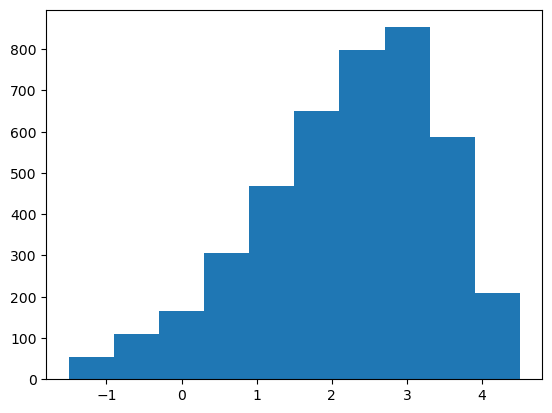

In [10]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (4200,)
Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21


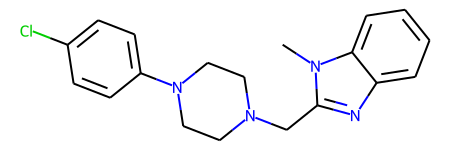

In [11]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [12]:
x_smiles = x_smiles
# [:10]
y = y
# [:10]

In [13]:
x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))


# Prepare Data Split

In [14]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "scaff"
# rand" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [15]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [16]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 2, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "sort_and_slice", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 1024, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [17]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [18]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [19]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : torch.nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 250,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = torch.nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = torch.nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = torch.nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = torch.nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [20]:
# # ECFP

# # dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
# scores_dict = {}

# # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
# for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
#     # create ecfp featuriser
#     featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
#                                         x_smiles_train = x_smiles[ind_train], 
#                                         y_train = y[ind_train], 
#                                         discretise_y = True if settings_dict["task_type"] == "regression" else False,
#                                         base = 2, 
#                                         random_state = 42)
    
#     # create ecfp-based feature matrices
#     X_train = featuriser(x_smiles[ind_train])
#     X_test = featuriser(x_smiles[ind_test])

#     # create ml model + train ml model + make predictions on test set
#     if settings_dict["ml_model"] == "rf":
        
#         rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
#         rf_model.fit(X_train, y[ind_train])
#         y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
#     if settings_dict["ml_model"] == "mlp":
        
#         mlp_model = create_mlp_model(settings_dict["mlp_settings"])
#         (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
#         plt.plot(loss_curve_train)
#         plt.plot(loss_curve_test)
#         y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
#     # record scores
#     print(m, k)
#     if settings_dict["task_type"] == "regression":
#         scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
#     elif settings_dict["task_type"] == "classification":
#         scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# # summarise, display and save scores for this experiment
# summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

In [21]:
def create_sort_and_slice_e3fp_featuriser(dataset_name,
                                          smiles_train,
                                          max_radius = 2, 
                                          pharm_atom_invs = False, 
                                          bond_invs = True, 
                                          chirality = False, 
                                          sub_counts = True, 
                                          vec_dimension = 1024, 
                                          break_ties_with = lambda sub_id: sub_id, 
                                          print_train_set_info = True):
    """
    Creates a function "ecfp_featuriser" that maps RDKit mol objects to vectorial extended-connectivity fingerprints (ECFPs) pooled via a trained Sort & Slice operator (instead of classical hash-based folding).
    See also "Sort & Slice: A Simple and Superior Alternative to Hash-Based Folding for Extended-Connectivity Fingerprints" by Dablander, Hanser, Lambiotte and Morris (2024): https://arxiv.org/abs/2403.17954
    
    
    
    INPUTS:
    
    - mols_train (list)            ...  A list of RDKit mol objects [mol_1, mol_2, ...] that are used as the training set to calibrate the Sort & Slice substructure pooling operator.
    
    - max_radius (int)             ...  The maximal radius up to which to generate the integer ECFP-substructure identifiers. Common choices are 1, 2 or 3 (corresponding to maximal diameters of 2, 4, or 6).
    
    - pharm_atom_invs (bool)       ...  If False (= default), then the standard initial atomic invariants from RDKit (including ring membership) are used to generate the ECFPs. 
                                        If True, then instead binary pharmacophoric initial atomic invariants are used to generate a different type of ECFP also referred to as FCFPs.
    
    - bond_invs (bool)             ...  Whether or not to take into account bond invariants when generating the integer ECFP-substructure identifiers (default = True).
    
    - chirality (bool)             ...  Whether or not to take into account chirality when generating the integer ECFP-substructure identifiers (default = False).
    
    - sub_counts (bool)            ...  Whether ecfp_featuriser should generate binary vectorial fingerprints (sub_counts = False) that indicate the mere presence or absence of substructures; 
                                        or integer fingerprints (sub_counts = True) that additionally indicate how many times a substructure is found in the input compound.
    
    - vec_dimension (int)          ...  Length of the vectorial Sort & Slice ECFP. Common choices are 512, 1024, 2048 and 4096. 
                                        Only the vec_dimension most prevalent ECFP-substructures in the training set mols_train are included in the final vector representation.
    
    - break_ties_with (function)   ...  Function to map the integer ECFP-substructure identifiers to values that are used to break ties when sorting the substructure identifiers according to their prevalence in mols_train. 
                                        The default is the identity map (i.e., lambda sub_id: sub_id) which breaks ties using the (arbitrary) ordering defined by the integer substructure identifier themselves.
                                        If break_ties_with = None, then ties are broken automatically as part of the application of Python's sorted() command to sub_ids_to_prevs_dict.
    
    - print_train_set_info (bool)  ...  Whether or not to print out the number of compounds and the number of unique integer ECFP-substructure identifiers with the specified parameters in mols_train.
    
    
    OUTPUT:
    
    - ecfp_featuriser (function)   ...  A function that maps RDKit mol objects to vectorial ECFPs (1-dimensional NumPy arrays of length vec_dimension) via a Sort & Slice substructure pooling operator trained on mols_train.
    
     
     
    EXAMPLE:
    
    First select a training set of RDKit mol objects 

        mols_train = [mol_1, mol_2, ...]
    
    that should be used to calibrate the Sort & Slice operator. This training set can then be employed along with a set of desired ECFP hyperparameter settings to construct a molecular featurisation function:
    
        ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train = mols_train, 
                                                                   max_radius = 2, 
                                                                   pharm_atom_invs = False, 
                                                                   bond_invs = True, 
                                                                   chirality = False, 
                                                                   sub_counts = True, 
                                                                   vec_dimension = 1024)
                                                               
    Then ecfp_featuriser(mol) is a 1-dimensional numpy array of length vec_dimension representing the vectorial ECFP for mol pooled via a Sort & Slice operator calibrated on mols_train. 
    
    More specifically, the function ecfp_featuriser can be thought of as

    1. first generating the (multi)set of integer ECFP-substructure identifiers for mol based on the ECFP hyperparameters (max_radius, pharm_atom_invs, bond_invs, chirality, sub_counts) and then
    2. vectorising this (multi)set via a Sort & Slice operator calibrated on mols_train with output dimension vec_dimension (rather than vectorising it via classical hash-based folding).
    
    To now turn any list of RDKit mol objects mols_list into a feature matrix X whose rows correspond to vectorial Sort & Slice ECFPs one can simply run
    
        X = np.array([ecfp_featuriser(mol) for mol in mols_list])
    
    """
    # if os.path.exists('e3fp_sub_ids_sorted_list/'+dataset_name+'_sub_ids_sorted_list.npy'):
    #     sub_ids_sorted_list = np.load('e3fp_sub_ids_sorted_list/'+dataset_name+'_sub_ids_sorted_list.npy')
    #     print('loaded sub_ids_sorted_list')
    # else:
    
    e3fp_generator = Fingerprinter(bits=1024, level=5, radius_multiplier=1.718, 
                    stereo=True, counts=False, include_disconnected=True, 
                    rdkit_invariants=False, exclude_floating=True, remove_duplicate_substructs=True)
    # mole = mols_train[0]
    substructures_per_mol = {}
    for smiles in smiles_train:
        mol = Chem.MolFromSmiles(smiles)
        mol.SetProp("_Name", smiles)
        mol = Chem.AddHs(mol, addCoords=True)
        AllChem.EmbedMolecule(mol, maxAttempts=5000)
        # , useRandomCoords=True)
        # AllChem.UFFOptimizeMolecule(mol)
        try:
            conf_ = mol.GetConformer()
            e3fp_generator.run(conf = conf_, mol = mol)
            substructures_per_mol[smiles] = e3fp_generator.get_all_shells().keys()
        except:
            print('bad conformer')
            continue 

    sub_ids_to_prevs_dict = {}
    for s in smiles_train:
        if s in substructures_per_mol.keys():
            for sub_id in substructures_per_mol[s] :
                sub_ids_to_prevs_dict[sub_id] = sub_ids_to_prevs_dict.get(sub_id, 0) + 1

    sub_ids_sorted_list = sorted(sub_ids_to_prevs_dict, key = lambda sub_id: (sub_ids_to_prevs_dict[sub_id], break_ties_with(sub_id)), reverse = True)
    # np.save('e3fp_sub_ids_sorted_list/'+settings_dict["dataset_name"]+'_sub_ids_sorted_list.npy', np.array(sub_ids_sorted_list))
    
    
    # create auxiliary function that generates standard unit vectors in NumPy
    def standard_unit_vector(dim, k):
        
        vec = np.zeros(dim, dtype = int)
        vec[k] = 1
        
        return vec
    
    # create one-hot encoder for the first vec_dimension substructure identifiers in sub_ids_sorted_list; all other substructure identifiers are mapped to a vector of 0s
    def sub_id_one_hot_encoder(sub_id):
        
        return standard_unit_vector(vec_dimension, sub_ids_sorted_list.index(sub_id)) if sub_id in sub_ids_sorted_list[0: vec_dimension] else np.zeros(vec_dimension)
    
    # create a function ecfp_featuriser that maps RDKit mol objects to vectorial ECFPs via a Sort & Slice substructure pooling operator trained on mols_train
    count_bad_conformers = 0
    def ecfp_featuriser(s):


        mol = Chem.MolFromSmiles(s)
        mol.SetProp("_Name", s)
        mol = Chem.AddHs(mol, addCoords=True)
        AllChem.EmbedMolecule(mol, maxAttempts=5000, useRandomCoords=True)
        # AllChem.UFFOptimizeMolecule(mol)
        try:
            conf_ = mol.GetConformer()
            e3fp_generator.run(conf = conf_, mol = mol)
            substructure_list = e3fp_generator.get_all_shells().keys()
            # create list of integer substructure identifiers contained in input mol object (multiplied by how often they are structurally contained in mol if sub_counts = True)
            if sub_counts == True:
                # breakpoint()
                
                sub_id_list = [sub_idd for (sub_id, count) in dict(Counter(substructure_list)).items() for sub_idd in [sub_id]*count]
            # else:
            #     sub_id_list = list(substructures_per_mol[s])
            
            # create molecule-wide vectorial representation by summing up one-hot encoded substructure identifiers
            ecfp_vector = np.sum(np.array([sub_id_one_hot_encoder(sub_id) for sub_id in sub_id_list]), axis = 0)
        
            # print('len ecfp_vector', len(ecfp_vector))
            return (ecfp_vector, x_smiles_to_y_dict[s])
            

        except:
            print('bad conformer')
            count_bad_conformers += 1
            return (None, None)
            
            # continue 
    
    # print information on training set
    if print_train_set_info == True:
        print('sub_ids_sorted_list', len(sub_ids_sorted_list))
        print('num of bad conformers', count_bad_conformers)
        print("Number of compounds in molecular training set which have conformers= ", len(substructures_per_mol))
        print("Number of unique circular substructures with the specified parameters in molecular training set = ", len(sub_ids_to_prevs_dict))

    return ecfp_featuriser

In [22]:
def discretise(y_cont, n_bins = 2, strategy = "uniform"):
    """
    Discretise continuous array.
    """
    
    discretiser = KBinsDiscretizer(n_bins = n_bins, encode = "ordinal", strategy = strategy)
    y_disc = list(discretiser.fit_transform(np.array(y_cont).reshape(-1,1)).reshape(-1).astype(int))
    
    return y_disc

In [23]:
from sklearn.feature_selection import mutual_info_classif

def create_mim_e3fp_featuriser(dataset_name,
                                  smiles_train,
                                  x_smiles_to_y_dict,
                                  vec_dimension=1024,
                                  print_train_set_info=True):
    
    e3fp_generator = Fingerprinter(bits=vec_dimension, level=5, radius_multiplier=1.718,
                                   stereo=True, counts=False, include_disconnected=True,
                                   rdkit_invariants=False, exclude_floating=True, remove_duplicate_substructs=True)
    
    substructures_per_mol = {}
    for smiles in smiles_train:
        mol = Chem.MolFromSmiles(smiles)
        mol.SetProp("_Name", smiles)
        mol = Chem.AddHs(mol, addCoords=True)
        AllChem.EmbedMolecule(mol, maxAttempts=5000)
        try:
            conf_ = mol.GetConformer()
            e3fp_generator.run(conf=conf_, mol=mol)
            substructures_per_mol[smiles] = list(e3fp_generator.get_all_shells().keys())
        except:
            print('bad conformer')
            continue
    
    # Compute frequency of substructures
    sub_ids_to_prevs_dict = Counter([sub_id for s in substructures_per_mol for sub_id in substructures_per_mol[s]])
    
    # Sort by frequency
    sub_ids_sorted_list = sorted(sub_ids_to_prevs_dict.keys(), key=lambda sub_id: sub_ids_to_prevs_dict[sub_id], reverse=True)
    
    # Selecting the most relevant features using Mutual Information
    def compute_mutual_info():
        X = []
        y = []
        
        for s in smiles_train:
            if s in substructures_per_mol:
                feature_vector = np.zeros(len(sub_ids_sorted_list))
                for sub_id in substructures_per_mol[s]:
                    if sub_id in sub_ids_sorted_list:
                        feature_vector[sub_ids_sorted_list.index(sub_id)] = 1
                X.append(feature_vector)
                y.append(x_smiles_to_y_dict[s])
        
        X = np.array(X)
        y = np.array(y)
        return mutual_info_classif(X, y = discretise(y, n_bins = 2, strategy = "quantile"), discrete_features=True)
    
    mi_scores = compute_mutual_info()
    top_features = np.argsort(mi_scores)[-vec_dimension:]
    
    # Folding into lower-dimensional representation
    def sub_id_folding_encoder(sub_id):
        if sub_id in sub_ids_sorted_list:
            idx = sub_ids_sorted_list.index(sub_id)
            if idx in top_features:
                folded_idx = np.where(top_features == idx)[0][0]  # Map to reduced dimension
                vec = np.zeros(vec_dimension)
                vec[folded_idx] = 1
                return vec
        return np.zeros(vec_dimension)
    
    # Function to featurize molecules
    def fingerprint_featuriser(s):
        mol = Chem.MolFromSmiles(s)
        mol.SetProp("_Name", s)
        mol = Chem.AddHs(mol, addCoords=True)
        AllChem.EmbedMolecule(mol, maxAttempts=5000, useRandomCoords=True)
        
        try:
            conf_ = mol.GetConformer()
            e3fp_generator.run(conf=conf_, mol=mol)
            substructure_list = list(e3fp_generator.get_all_shells().keys())
            folded_vector = np.sum(np.array([sub_id_folding_encoder(sub_id) for sub_id in substructure_list]), axis=0)
            return (folded_vector, x_smiles_to_y_dict[s])
        except:
            print('bad conformer')
            return (None, None)
    
    if print_train_set_info:
        print('Dataset:', dataset_name)
        print('Unique substructures:', len(sub_ids_sorted_list))
        print('Selected features:', len(top_features))
    
    return fingerprint_featuriser


In [24]:
settings_dict["ml_model"] = "mlp" # "rf" or "mlp"

Dataset: moleculenet_lipophilicity
Unique substructures: 1871
Selected features: 1024
[(array([0., 0., 0., ..., 0., 1., 0.]), 3.7), (array([0., 0., 0., ..., 1., 1., 0.]), 3.16), (array([0., 0., 0., ..., 1., 1., 0.]), 3.59), (array([0., 0., 0., ..., 0., 1., 1.]), 1.3), (array([0., 0., 0., ..., 0., 1., 0.]), 0.36), (array([0., 0., 0., ..., 0., 1., 1.]), 1.95), (array([0., 0., 0., ..., 0., 1., 0.]), 1.92), (array([0., 0., 0., ..., 0., 1., 0.]), 2.34), (array([0., 0., 0., ..., 0., 1., 0.]), 2.06), (array([0., 0., 0., ..., 0., 1., 0.]), -0.08), (array([0., 0., 0., ..., 0., 0., 0.]), 3.4), (array([0., 0., 0., ..., 0., 1., 0.]), 1.6), (array([0., 0., 0., ..., 0., 0., 0.]), 3.4), (array([0., 0., 0., ..., 1., 1., 0.]), 2.77), (array([0., 0., 0., ..., 0., 1., 0.]), 2.8), (array([0., 0., 0., ..., 0., 1., 0.]), 3.77), (array([0., 0., 0., ..., 0., 1., 0.]), 2.14), (array([0., 0., 0., ..., 1., 0., 0.]), 3.47), (array([0., 0., 0., ..., 0., 1., 0.]), 1.72), (array([0., 0., 0., ..., 1., 1., 0.]), 2.48)

100%|██████████| 250/250 [00:42<00:00,  5.82it/s]


seed:  0  fold:  0


,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Scores:,2.428033,2.581965,2.666146,4.487444,7.108333,0.027401,-3.032902,50.0


Dataset: moleculenet_lipophilicity
Unique substructures: 1950
Selected features: 1024


KeyboardInterrupt: 

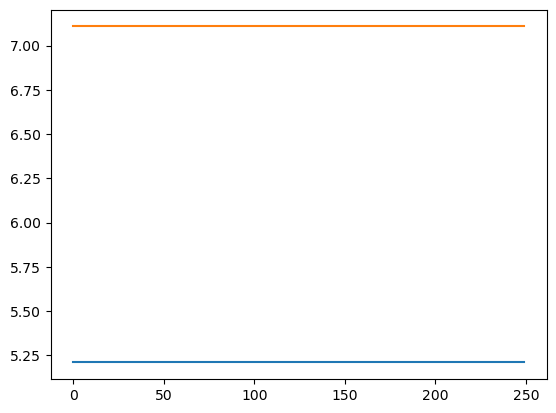

In [25]:
# E3fp sns

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_mim_e3fp_featuriser(dataset_name= settings_dict["dataset_name"],
                                                       smiles_train = x_smiles[ind_train],
                                                         x_smiles_to_y_dict = x_smiles_to_y_dict,
                                          vec_dimension = 1024, 
                                          print_train_set_info = True)
    

    return_train = list(map( featuriser , x_smiles[ind_train]))
    return_test = list(map( featuriser , x_smiles[ind_test]))

    X_train = []
    y_train = []
    X_test = []
    y_test = []


    print(return_train)
    for (x,y) in return_train:
        if x is not None and y is not None:
            X_train.append(x)
            y_train.append(y)
    
    for (x,y) in return_test:
        if x is not None and y is not None:
            X_test.append(x)
            y_test.append(y)

    X_train= np.array(X_train)
    X_test= np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        X_train= np.array(X_train)
        rf_model.fit(X_train, y_train)
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        print('y_test_pred', y_test_pred.shape)
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y_train, X_test, y_test)
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print('seed: ', m, ' fold: ', k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y_test, y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

In [26]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
# delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["sort_and_slice","hashed", "filtered", "mim"]:
    for dimension in [1024, 512, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}


                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    print("creating featuriser")
                    print(y)
                    featuriser = create_sort_and_slice_e3fp_featuriser(dataset_name= settings_dict["dataset_name"],
                                                        smiles_train = x_smiles[ind_train], 
                                                        max_radius = 2, 
                                                            pharm_atom_invs = False, 
                                                            bond_invs = True, 
                                                            chirality = False, 
                                                            sub_counts = True, 
                                                            vec_dimension = 1024, 
                                                            break_ties_with = lambda sub_id: sub_id, 
                                                            print_train_set_info = True
                    )                                          



                    return_train = list(map( featuriser , x_smiles[ind_train]))
                    return_test = list(map( featuriser , x_smiles[ind_test]))

                    print(return_train)
                    X_train = []
                    y_train = []
                    X_test = []
                    y_test = []


                    print(return_train)
                    for (x,y) in return_train:
                        if x is not None and y is not None:
                            X_train.append(x)
                            y_train.append(y)
                    
                    for (x,y) in return_test:
                        if x is not None and y is not None:
                            X_test.append(x)
                            y_test.append(y)

                    X_train= np.array(X_train)
                    X_test= np.array(X_test)
                    y_train = np.array(y_train)
                    y_test = np.array(y_test)

                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y_train)
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y_test, y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y_train, X_test, y_test)
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y_test, y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y_test, y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

pool_method =  sort_and_slice
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fda13abca70>
radius =  1 

creating featuriser
[ 3.54 -1.18  3.69  3.37  3.1   3.14 -0.72  0.34  3.05  2.25  1.51  2.61
 -0.08  1.95  1.34  3.2   1.6   3.77  3.15  0.32  2.92  1.92  3.17  2.17
  1.2   3.93  1.9   2.27  1.2   1.14  2.6   3.3   3.94  2.34  2.57  3.62
  2.06  4.33  2.55  2.78  1.4  -0.54  2.91 -0.4  -0.16  2.2   3.4   1.1
  2.28  3.47  3.   -1.17  1.95 -0.99  2.    3.8   3.21  0.36  2.14  1.71
  1.19  2.7   2.77  3.8   2.87  1.91  3.4   3.13  3.    2.33  2.8  -0.54
  3.16  2.91  1.55  0.2   1.43  2.47  2.48 -0.45  2.    2.6   3.5   0.89
  1.3   2.01  3.59  0.18  2.6   1.3   2.1   3.72  1.72  1.65  3.7   2.2
  2.04  4.49  0.2   2.  ]
sub_ids_sorted_list 1871
num of bad conformers 0
Number of compounds in molecular training set which have conformers=  50
Number of unique circular substructures with the specified parameters in molecular training set =  1871
[(array([1., 1., 1., ..., 0

KeyboardInterrupt: 

# Visualisation of Results

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

results/moleculenet_lipophilicity/scaff/
results_dict>>>>>>>>>>>>> {(1024, 'ecfp', 4, 'sort_and_slice', 'mlp'): (2.2366372404432178, 0.1352256441556102)}


KeyError: (512, 'ecfp', 2, 'hashed', 'rf')

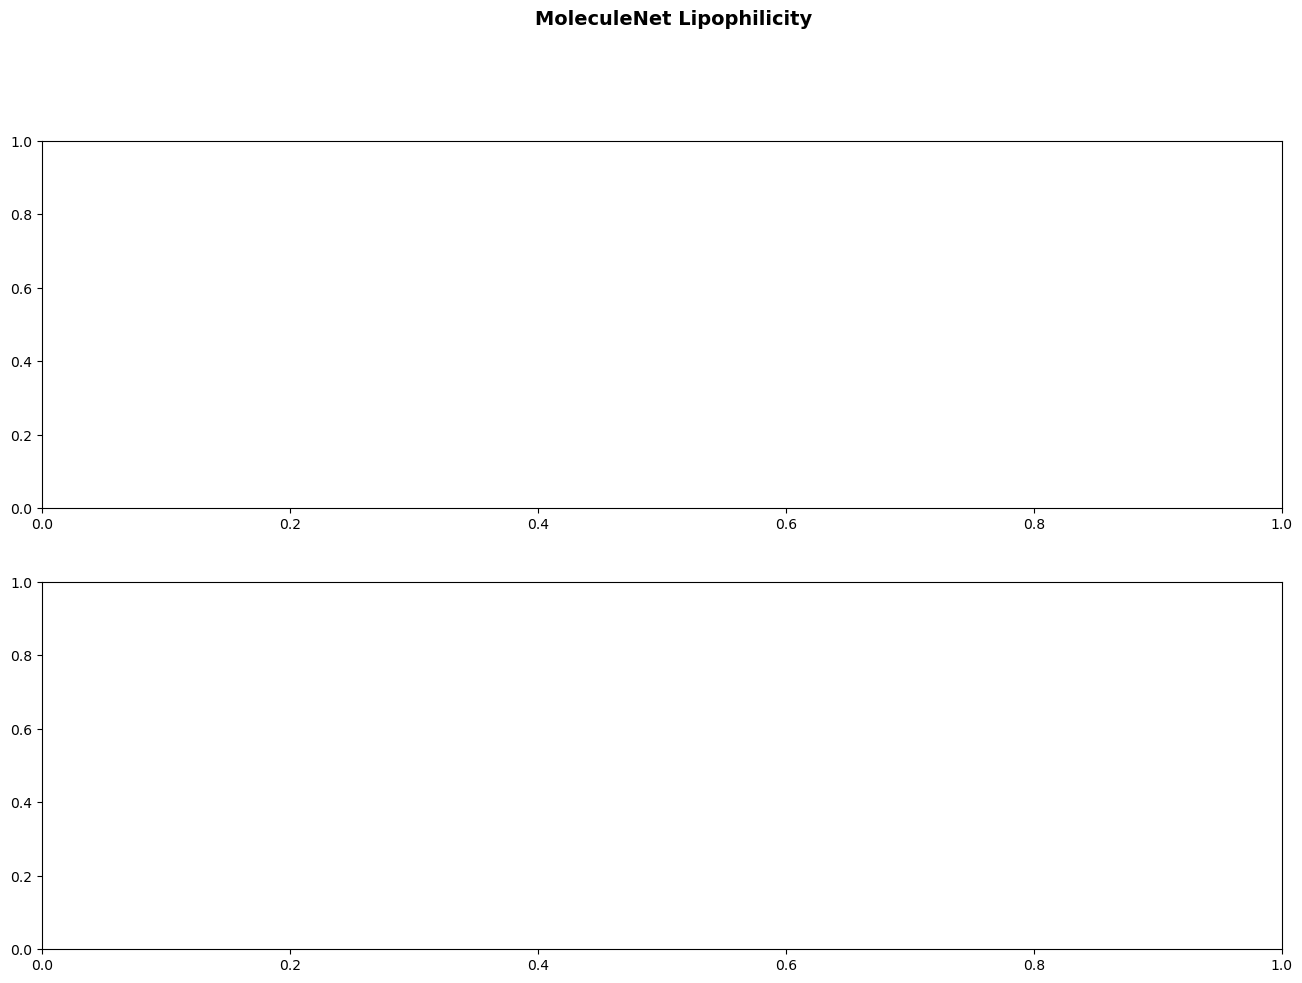

In [30]:
visualise_bar_charts(dataset_name = "moleculenet_lipophilicity", # specify dataset name
                     split_type = "scaff", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "MAE", # specify performance metric,
                     y_lims = None, # specify limits of y-axis (set to "None" for automatic limits)
                     y_unit = " [logD]") # specify unit for y-axis (if applicable)

In [28]:
visualise_box_plots(dataset_name = "moleculenet_lipophilicity", # specify dataset name,
                    metric = "MAE", # specify performance metric
                    y_unit = " [logD]", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

TypeError: visualise_box_plots() got an unexpected keyword argument 'split_type'